Luiz Bossetto - CS387 Final Project

# Captcha Recognition Model

This project is an approach to solving text-based Captcha images (reCatpcha) using deep learning concepts related to image classification. This notebook contains all the steps taken to tackle this challenge head-on, from data preprocessing to model development, training, and evaluation. This notebook aims to demonstrate the effectiveness of deep learning in overcoming CAPTCHA challenges.

# Step by step
I have decided to approach this challenge by breaking the problem down into smaller steps:

1. Setup - All requirements will be installed in the notebook.  
2. Data Processing - Given a dataset of captcha images, the model will pass them to a noise reduction filter. This filter will be responsible for removing the noise present in the image.
3. Data segmentation - After the images are passed to the nosie reduction filter, the model will crop the characters ("areas of interest") and store them in a folder for character classification.
4. Data setup - Save all images in a custom dataset class. This can be used using pytorch's tools from <code>torch.utils.data</code>.
5. Training - The model wil be trained on the cropped characters from the denoised images provided by the noise reduction filter. This is a character classification problem that will involve 35 possible classes.
6. Evalutation - The model will be evaluated using both the training and test set created by a random data split to avoid any possible bias. In this step, I aim to find the best hyperparameters for maximized performance.


## 1. Setup

For this project, a few python modules were necessary:

* OpenCV (cv2) -- OpenCV is a library of programming functions mainly for real-time computer vision. This will be used in the data preprocessing and segmentation step.
* Numpy -- NumPy is a library that adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions. This will be used in the preprocessing and segmentation step.
* Matplotlib -- Matplotlib is a plotting library. It provides an API for embedding plots into applications. This will be used in the model evaluation step.
* Captcha -- Captcha is a module that is able to generate reCaptcha images. This will be used in the dataset generation step.
* Torch -- PyTorch is a machine learning library based on the Torch library, used for applications such as computer vision and natural language processing. This will be used as the main framework throughout the whole project.
* PIL (Python Imaging Library) -- PIL is a library for thethat adds support for opening, manipulating, and saving many different image file formats.
* random -- Random is a module that implements pseudo-random number generators for various distributions. This will be used in sampling text for the captcha images in the dataset generation.
* os -- The OS module provides a portable way of using operating system dependent functionality. In particular, this will be used in the dataprocessing step to properly store data in the right folders. <br><br>




In [62]:
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install captcha

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
from torch.utils.data import DataLoader,Dataset, random_split
from torch import optim
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt # plotting data after evaluation
import random # sampling captcha text
import os # used for path and image storage
from captcha.image import ImageCaptcha  # Module that will generate all captcha images# pip install captcha


In [3]:
# Set device to point to a GPU if we have one, CPU otherwise.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 2. Data Preprocessing
This step contains important methods for data preprocessing. They include: 

### <code>remove_noise(image_path, save_path)</code> 
This is the function that will be responsible for removing the noise in the captcha images using functionalities from the cv2 module. <br>

#### How it works
1. The filter first converts the image to grayscale to make it easier to deal with the colors.
2. Turns the new image into a numpy array to apply binary thresholding (binarization).
3. Apllies binary thresholding that will turn the image into a black-and-white image.
4. Apply morphological operations using a 3x3 kernel to remove the noise from the image.
5. Turns this black-and-white image (with gray pixels) into a pure black and white image through bitwise operations. This will normalize the data by keeping the range of its pixels in between 0 and 1 instead of 0 and 255.
6. After this process, the new image is stored in a folder.

It takes two parameters: <br>
* <code>image_path</code>: where the image is located (folder).
* <code>save_path</code>: where the new dataset will be stored (folder).



In [8]:
def remove_noise(image_path, save_path):
    # Open the image using Pillow
    image = Image.open(image_path)

    # Convert the image to grayscale
    gray_image = image.convert('L')

    # Convert PIL image to numpy array
    np_image = np.array(gray_image)

    # Apply binary thresholding
    _, binary_image = cv2.threshold(np_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Apply morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)

    # Invert the binary image
    inverted_image = cv2.bitwise_not(opening)

    # Save the inverted binary image
    inverted_image_pil = Image.fromarray(inverted_image)

    # Invert the colors again to have black background and white letters
    inverted_image_pil = inverted_image_pil.convert('L')
    inverted_image = np.array(inverted_image_pil)
    inverted_image = cv2.bitwise_not(inverted_image)

    # Save the final image in output directory
    final_image = Image.fromarray(inverted_image)
    final_image.save(save_path)


## 3. Data Segmentation
This step involves image segmentation. The images generated by the <code>remove_noise()</code> method will be transferred to a method that will be responsible for identifying the areas of interest, or characters.
<br>

### <code>resize_image(image, new_width, new_height)</code> 
This is the function that will be responsible for resizing the cropped characters from the denoised images generated by the <code>remove_noise()</code> function. This step is considered part of the data normalization process by resizing all images that will be transferred to the network to a standard size. <br>

#### How it works
1. It takes images of different shapes and resizes them to a new <code>new_width</code> x <code>new_height</code> image.
2. Applies binary thresholding to ensure black and white pixels only. While working on this method, it could be seen that the resized image would not be pure black and white, so binary thresholding was added to prevent this.
3. Returns a resized image. 

It takes two parameters: <br>
* <code>image_path</code>: where the image is located (folder).
* <code>save_path</code>: where the new dataset will be stored (folder).



In [9]:
# Resize the image
def resize_image(image, new_width, new_height):
    # Resize the image
    resized_image = cv2.resize(image, (new_width, new_height))

    # Apply binary thresholding to ensure black and white pixels only
    _, binary_image = cv2.threshold(resized_image, 127, 255, cv2.THRESH_BINARY)

    # Return the final inverted image
    return binary_image

<br>

### <code>save_contours_as_images(image_path, output_directory, image_id)</code> 
This is the function that will be responsible for the selection of areas of interest in a given denoised image generated by the <code>remove_noise()</code> function.

#### How it works
1. It takes a full denoised images and crops contours that are identified by the <code>cv2.findcontours()</code> function.
2. Since all "entities" are considered contours to this cv2 method, the function should classify which ones are characters and which ones are just noise. This is done by checking the dimensions of the contours. Since all noise follows a similar dimensional pattern, (5x5 pixels), an if statement checking the width and height of each contour is enough to filter the characters from the noise.
3. Renames the image to its label, for later label organization.

It takes three parameters: <br>
* <code>image_path</code>: where the image is located (folder).
* <code>output_directory</code>: where the new dataset will be stored (folder).
* <code>image_id</code>: an ID to the new generated character image. This is important to prevent file name duplicates. In case images have the the same name, the newly generated one will replace the one that already exists in the folder.



In [7]:
def save_contours_as_images(image_path, output_directory, image_id):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to obtain binary image
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours based on x-coordinate.
    # The reason for this is so the images can be correctly labeled to prevent mislabeled data in the future.
    contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])

    # Create output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    counter = 0 # keep track of how many characters have been saved
    
    # extract label from image file's name
    label = image_path.split('/')[0].split('.')[0].split("\\")[1]
    image_name = label.split("--")[0]
    char_labels = [char_label for char_label in label.split("_")[0]]
    
    for i, contour in enumerate(contours):
        # Get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)

        # if 4 characters have been extracted, break.
        if counter > 3:
            break

        # Check if contour is too small (possibly noise)
        if w > 5 and h > 5:
            # Add some padding around the character bounding box
            padding = 10
            x_padding = max(0, x - padding)
            y_padding = max(0, y - padding)
            w_padding = min(image.shape[1], w + 2 * padding)
            h_padding = min(image.shape[0], h + 2 * padding)

            # Create a black canvas with padded dimensions
            padded_image = np.zeros((h_padding, w_padding), dtype=np.uint8)

            # Calculate coordinates to place the character in the center
            x_offset = (w_padding - w) // 2
            y_offset = (h_padding - h) // 2

            # Copy the character region from the original image to padded image
            padded_image[y_offset:y_offset+h, x_offset:x_offset+w] = image[y:y+h, x:x+w]

            # Resize the padded image
            resized_image = resize_image(padded_image, 100, 100)

            # Save the resized image as a separate image
            character_filename = os.path.join(output_directory, f'{image_name}_{char_labels[counter]}--{image_id}.png')
            cv2.imwrite(character_filename, resized_image)
            counter += 1 # adding one to the counter variable means that the method has found one of the four characters.
            image_id += 1

In [10]:
# Folder path containing the images
folder_path = 'testing'

# Output directory for saved contour images
output_directory = 'cropped_testing'

# Get list of all files in the folder
file_list = os.listdir(folder_path)

image_id = 0 # variable to keep track of each image's ID

# Iterate through each image with no noise
for i, filename in enumerate(file_list):
    # Check if the file is an image
    if filename.lower().endswith(('.png')):
        # Construct the full path to the denoised image
        image_path = os.path.join(folder_path, filename)
        # Extract areas of interest from denoised image
        save_contours_as_images(image_path, output_directory, image_id)

        image_id += 4

### Passing images to the filter (new image generation)

This code snippet will run the dataset through the noise reduction filter, and store the outputs in a folder.

In [5]:
# Generate denoised images. Do not run this code snippet if folder and data already exists.
folder = 'captcha_images'
output_folder = 'denoised_images'

# Get list of all files in the folder
file_list = os.listdir(folder)

# Iterate through the first 10 images in the folder
for i, filename in enumerate(file_list):    
    # Check if the file is an image (you can add more image extensions if needed)
    if filename.lower().endswith(('.png')):
        # Construct the full path to the image
        image_path = os.path.join(folder, filename)
        
        # Save path for the denoised image
        # original image -> denoised image (now named after its label)
        label = filename.split('-')[0]
        save_filename = f'{label}_{i}--denoised.png'
        save_path = os.path.join(output_folder, save_filename)
        
        # Call the remove_noise function
        remove_noise(image_path, save_path)


### Cropping Characters (New Image Generation)
This code snippet will run the dataset through the character selection filter, and store the outputs in a folder.

In [6]:
# Folder path containing the images
folder_path = 'denoised_images'

# Output directory for saved contour images
output_directory = 'cropped_grayscale'

# Get list of all files in the folder
file_list = os.listdir(folder_path)

image_id = 0 # variable to keep track of each image's ID

# Iterate through each image with no noise
for i, filename in enumerate(file_list):
    # Check if the file is an image
    if filename.lower().endswith(('.png')):
        # Construct the full path to the denoised image
        image_path = os.path.join(folder_path, filename)
        # Extract areas of interest from denoised image
        save_contours_as_images(image_path, output_directory, image_id)

        image_id += 4

contour saved: cropped_characters\1191_0_1--0.png
contour saved: cropped_characters\1191_0_1--1.png
contour saved: cropped_characters\1191_0_9--2.png
contour saved: cropped_characters\1191_0_1--3.png


contour saved: cropped_characters\11A1_1_1--4.png
contour saved: cropped_characters\11A1_1_1--5.png
contour saved: cropped_characters\11A1_1_A--6.png
contour saved: cropped_characters\11A1_1_1--7.png
contour saved: cropped_characters\11CQ_2_1--8.png
contour saved: cropped_characters\11CQ_2_1--9.png
contour saved: cropped_characters\11CQ_2_C--10.png
contour saved: cropped_characters\11CQ_2_Q--11.png
contour saved: cropped_characters\11H9_3_1--12.png
contour saved: cropped_characters\11H9_3_1--13.png
contour saved: cropped_characters\11H9_3_H--14.png
contour saved: cropped_characters\11H9_3_9--15.png
contour saved: cropped_characters\11IJ_4_1--16.png
contour saved: cropped_characters\11IJ_4_1--17.png
contour saved: cropped_characters\11IJ_4_I--18.png
contour saved: cropped_characters\11IJ_4_J--19.png
contour saved: cropped_characters\11LG_5_1--20.png
contour saved: cropped_characters\11LG_5_1--21.png
contour saved: cropped_characters\11LG_5_L--22.png
contour saved: cropped_characters\11L

### 4. Data Setup
After all data has gone through the preprocessing and segmentation steps, the new data will then be transferred to a custom dataset. This dataset will be the one responsible for storing all the information needed for future training, such as <code>images</code> and <code>labels</code>.
<br><br>
The dataset will take two parameters:
* <code>root_dir</code>: this is the folder where all the new data is located.
* <code>transform</code>: this parameter stores all transformations that will be applied to the information in the dataset.

For this task specifically, the data will be stored in a tuple that will use the following format: <code>(tensor([[image]]), label)</code>

For reference, the code template used in this step can be found here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
This link contains a template, the step by step process on how to build a custom dataset, and how to properly store the information in it.

In this project, the data was generated by gathering samples of 35 different classes. They include digits that range from 1 to 9, and upper case characters that range from A to Z. 


In [6]:
classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] # 35 classes

In [8]:
class CroppedCharacterDataset(Dataset):
    # Constructor
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # where the data is located (folder)
        self.transform = transform # a transforms.Compose() that contains all data transformations
        # image paths are stored in an array for easy iteration over the data
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith('.png')]

    # returns dataset size
    def __len__(self):
        return len(self.image_paths)

    # returns a tensor that contains the image and the label of that image, given an index.
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert image to grayscale
        
        # Extract label and image id from file name
        filename = os.path.splitext(os.path.basename(img_path))[0]

        # format used in the image file name creation: {ParentImageName}_{image_num}_{char_label}--{id}.png
        parts = filename.split('_')
        label, image_id = parts[-1].split('--')  # Split last part
        label = label.strip()  # Remove any leading/trailing whitespace

        # apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

### Creating instances and dataset visualization
The following code snippet defines the transformations that will be applied to the dataset, creates an instance of a dataset, and shows how the data is accessed through the magic methods defined in the class.

In [9]:
# root directory where images are stored
root_dir = "./cropped_grayscale"

# Define transformations. Here, since the previous filters already normalized all the data, 
# the only transformation that will be applied to the dataset will be turning it into tensors.
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset instance
cropped_chars_dataset = CroppedCharacterDataset(root_dir, transform=transform)

# Demonstration of how the data in the dataset is accessed and stored.
print(f"Number of images in the dataset: {len(cropped_chars_dataset)}\n") 
print("Example of a tensor stored in the dataset:")
print(cropped_chars_dataset[0])

Number of images in the dataset: 40415

Example of a tensor stored in the dataset:
(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'S')


<br>

### Train and Test Sets
This section covers how the train and test sets are defined. 

In this project used an 80%/20% split between both sets. Since the <code>cropped_chars_dataset</code> contains 40415 different images, this split is enough to train and evaluate the model later. 

The random splitting was done by storing the dataset size in separate variables defined <code>train_size</code> and <code>test_size</code>. With these variables, it was possible to call the <code>random_split</code> function that will do the job of randomly splitting the data into two different sets of the given sizes. 

After that, <code>Dataloaders</code> were created for each set. These will be used later in the training step.

In [10]:
# Define the sizes of each split
train_size = int(0.8 * len(cropped_chars_dataset))
test_size = len(cropped_chars_dataset) - train_size

# Split dataset into train, and test sets
train_data, test_data = random_split(cropped_chars_dataset, [train_size, test_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True) 

# Visualize training and dataset sizes
print(f"Train: {len(train_loader.dataset)} examples into {len(train_loader)} batches")
print(f"Test: {len(test_loader.dataset)} examples into {len(test_loader)} batches")

Train: 32332 examples into 1011 batches
Test: 8083 examples into 253 batches


# Model

Since this part of the project deals with image recognition and classification, a Convolutional Neural Network (CNN) is the perfect fit for this task.

This model contains 3 different <code>conv2d</code> (convolutional) layers with a <code>padding</code> of 1, followed by 3x3 <code>kernels</code>. In between each layer, a 2x2 <code>MaxPool2d</code> was included as a way to downsample the spatial dimensions of the input feature and reduces their size while preserving important information.

In [14]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=35):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 12 * 12, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 12 * 12)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Training

In [20]:
def train_model(model, train_loader, num_epochs, learning_rate, loss_arr, acc_arr):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            
            # Extract and convert labels to integers
            label_strings = [label_tuple[0] for label_tuple in labels]
            label_indices = [classes.index(label) for label in label_strings]
            
            labels = torch.tensor(label_indices, dtype=torch.long).to(device)
            
            # zero the gradients
            optimizer.zero_grad()

            # forward propagation
            outputs = model(images)

            # computer loss
            loss = criterion(outputs, labels)
            
            # backward prop
            loss.backward()

            # update
            optimizer.step()
            
            # calculating stats
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item() * images.size(0)
        
        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {100 * train_accuracy:.2f}%")
        
        loss_arr.append(train_loss)
        acc_arr.append(train_accuracy)
        

In [27]:
# Get ResNet18 model with randomized weights
model = CNNModel()

epochs = 10
learning_rate = 0.0001

# lists to store information that will be used to plot the results.
losses_train = []
accuracies_train = []

losses_test = []
accuracies_test = []


# Check accuracies on both test and training datasets
print("Training Model...")
train_model(model, test_loader, epochs, learning_rate, losses_train, accuracies_train)
print()
print("Tesing Model...")
train_model(model, test_loader, epochs, learning_rate, losses_test, accuracies_test)

Training Model
Epoch [1/10], Train Loss: 1.4538, Train Accuracy: 60.00%
Epoch [2/10], Train Loss: 0.2551, Train Accuracy: 92.12%
Epoch [3/10], Train Loss: 0.1218, Train Accuracy: 96.65%
Epoch [4/10], Train Loss: 0.0731, Train Accuracy: 97.98%
Epoch [5/10], Train Loss: 0.0552, Train Accuracy: 98.45%
Epoch [6/10], Train Loss: 0.0279, Train Accuracy: 99.26%
Epoch [7/10], Train Loss: 0.0213, Train Accuracy: 99.43%
Epoch [8/10], Train Loss: 0.0130, Train Accuracy: 99.67%
Epoch [9/10], Train Loss: 0.0187, Train Accuracy: 99.57%
Epoch [10/10], Train Loss: 0.0111, Train Accuracy: 99.69%

Tesing Model
Epoch [1/10], Train Loss: 0.0220, Train Accuracy: 99.27%
Epoch [2/10], Train Loss: 0.0243, Train Accuracy: 99.41%
Epoch [3/10], Train Loss: 0.0092, Train Accuracy: 99.72%
Epoch [4/10], Train Loss: 0.0095, Train Accuracy: 99.74%
Epoch [5/10], Train Loss: 0.0099, Train Accuracy: 99.74%
Epoch [6/10], Train Loss: 0.0111, Train Accuracy: 99.64%
Epoch [7/10], Train Loss: 0.0028, Train Accuracy: 99.94%
E

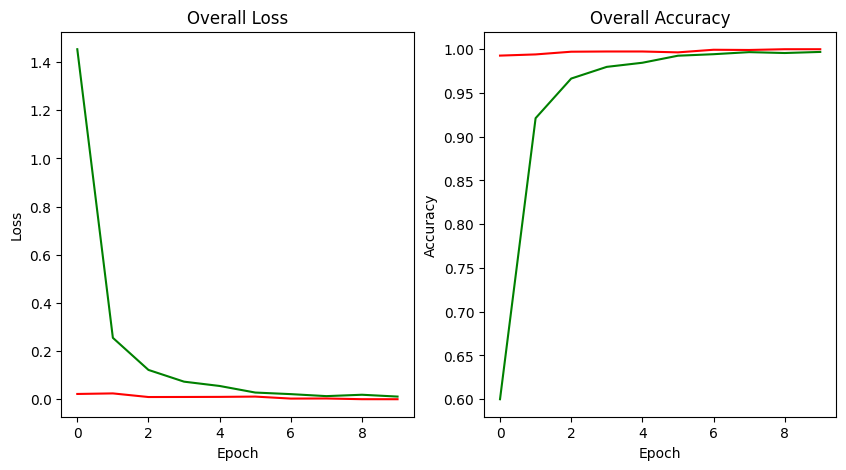

In [31]:
# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train, color="green")
plt.plot(losses_test, color="red")
plt.title('Overall Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies_train, color="green")
plt.plot(accuracies_test, color="red")
plt.title('Overall Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()